# Predicting Daily PM2.5

In [171]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from xgboost import plot_importance
from matplotlib.patches import Patch
root_dir = Path().absolute()

In [187]:
today = datetime.datetime.now() - datetime.timedelta(1)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 15, 16, 32, 41, 581888)

In [173]:
project = hopsworks.login(project='akeelaf')
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()

2025-11-16 16:30:07,950 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 16:30:07,954 INFO: Initializing external client
2025-11-16 16:30:07,955 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-16 16:30:09,240 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1277076


In [174]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=3,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-16 16:30:17,974 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/10600048 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/66133 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/39745 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/48233 elapsed<00:00 remaining<?

In [175]:
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.280892E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [176]:
REGION = "west"
pm25_daily_fg = fs.get_feature_group(
    name="pm25_daily",
    version=4
)
wind_direction_daily_fg = fs.get_feature_group(
    name="wind_direction_daily",
    version=4
)

wind_speed_daily_fg = fs.get_feature_group(
    name="wind_speed_daily",
    version=4
)

air_temperature_daily_fg = fs.get_feature_group(
    name="air_temperature_daily",
    version=4
)

print("pm25_daily_fg:", "Loaded" if pm25_daily_fg is not None else "Not Loaded")
print("wind_direction_daily_fg:", "Loaded" if wind_direction_daily_fg is not None else "Not Loaded")
print("wind_speed_daily_fg:", "Loaded" if wind_speed_daily_fg is not None else "Not Loaded")
print("air_temperature_daily_fg:", "Loaded" if air_temperature_daily_fg is not None else "Not Loaded")

base_query = pm25_daily_fg.select_all().filter(pm25_daily_fg.timestamp >= today).filter(pm25_daily_fg.region == REGION)
joined_query = (
    base_query
        .join(
            wind_direction_daily_fg.select_all(),
            on=["timestamp", "region"]
        )
        .join(
            wind_speed_daily_fg.select_all(),
            on=["timestamp", "region"]
        )
        .join(
            air_temperature_daily_fg.select_all(),
            on=["timestamp", "region"]
        )
)
batch_data = joined_query.read()
batch_data

pm25_daily_fg: Loaded
wind_direction_daily_fg: Loaded
wind_speed_daily_fg: Loaded
air_temperature_daily_fg: Loaded
2025-11-16 16:30:29,017 WARNING: Ambiguous features detected during query construction.The feature `region` is present in feature groups ['air_temperature_daily version 4', 'pm25_daily version 4', 'wind_direction_daily version 4', 'wind_speed_daily version 4']. The feature `timestamp` is present in feature groups ['air_temperature_daily version 4', 'pm25_daily version 4', 'wind_direction_daily version 4', 'wind_speed_daily version 4']. The feature `day_of_week` is present in feature groups ['air_temperature_daily version 4', 'pm25_daily version 4', 'wind_direction_daily version 4', 'wind_speed_daily version 4']. The feature `day_of_month` is present in feature groups ['air_temperature_daily version 4', 'pm25_daily version 4', 'wind_direction_daily version 4', 'wind_speed_daily version 4']. The feature `month` is present in feature groups ['air_temperature_daily version 4',

,region,timestamp,pm25,day_of_week,day_of_month,month,year,is_weekend,pm25_lag_1d,pm25_lag_2d,...,air_temperature_daily_air_temperature_rolling_min_7d,air_temperature_daily_air_temperature_rolling_max_7d,air_temperature_daily_air_temperature_rolling_mean_14d,air_temperature_daily_air_temperature_rolling_std_14d,air_temperature_daily_air_temperature_rolling_min_14d,air_temperature_daily_air_temperature_rolling_max_14d,air_temperature_daily_air_temperature_rolling_mean_28d,air_temperature_daily_air_temperature_rolling_std_28d,air_temperature_daily_air_temperature_rolling_min_28d,air_temperature_daily_air_temperature_rolling_max_28d
0,west,2025-11-16 00:00:00+00:00,8.375,6,16,11,2025,True,63.0,55.0,...,28.700093,30.325231,29.064726,0.927884,27.220093,30.325231,28.716997,0.818667,27.220093,30.325231


In [177]:
booster = retrieved_xgboost_model.get_booster()
model_features = booster.feature_names
print(len(model_features))
print(model_features[:20])

138
['pm25_lag_1d', 'pm25_lag_2d', 'pm25_lag_3d', 'pm25_lag_7d', 'pm25_lag_14d', 'pm25_rolling_mean_3d', 'pm25_rolling_mean_7d', 'pm25_rolling_mean_14d', 'pm25_rolling_mean_28d', 'pm25_rolling_min_3d', 'pm25_rolling_min_7d', 'pm25_rolling_min_14d', 'pm25_rolling_min_28d', 'pm25_rolling_max_3d', 'pm25_rolling_max_7d', 'pm25_rolling_max_14d', 'pm25_rolling_max_28d', 'wind_direction_daily_wind_direction_avg_mean', 'wind_direction_daily_wind_direction_avg_max', 'wind_direction_daily_wind_direction_avg_min']


In [178]:
data_features = list(batch_data.columns)

missing = set(model_features) - set(data_features)
extra   = set(data_features) - set(model_features)

print("MISSING (expected by model, not in batch_data):")
print(sorted(missing))

print("\nEXTRA (in batch_data, not used by model):")
print(sorted(extra))


MISSING (expected by model, not in batch_data):
[]

EXTRA (in batch_data, not used by model):
['air_temperature_daily_is_weekend', 'day_of_month', 'day_of_week', 'is_weekend', 'month', 'pm25', 'pm25_lag_28d', 'pm25_lag_4d', 'pm25_lag_5d', 'pm25_lag_6d', 'pm25_rolling_std_14d', 'pm25_rolling_std_28d', 'pm25_rolling_std_3d', 'pm25_rolling_std_7d', 'region', 'timestamp', 'wind_direction_daily_is_weekend', 'wind_speed_daily_is_weekend', 'year']


In [179]:
booster = retrieved_xgboost_model.get_booster()
model_features = booster.feature_names  # this is the exact training order

# (You’ve already checked that set(model_features) == set(batch_data.columns))

# 1) Make sure we don't have any weird non-numeric types
prediction_data = batch_data[model_features].astype(float)

In [180]:
# batch_data = batch_data.drop(columns = ['station_name', 'region', 'timestamp', 'wind_speed_daily_station_name', 'air_temperature_daily_station_name', 'station_name', 'direction_std_rolling_mean_28d', 'wind_v_rolling_mean_14d', 'wind_v_lag_1d', 'wind_u_lag_3d', 'latitude', 'wind_direction_lag_7d', 'wind_u_lag_5d', 'direction_std_rolling_mean_14d', 'wind_u_rolling_mean_14d', 'day_of_month', 'is_weekend', 'longitude', 'wind_direction_avg_min', 'wind_u_lag_6d', 'wind_direction_lag_1d', 'year', 'air_temperature_daily_is_weekend', 'month', 'wind_direction_lag_14d', 'wind_direction_lag_2d', 'wind_u', 'wind_v_lag_6d', 'wind_v_lag_7d', 'wind_u_rolling_mean_3d', 'wind_direction_avg_std', 'wind_direction_lag_4d', 'wind_u_lag_1d', 'wind_u_lag_2d', 'wind_v_lag_28d', 'wind_direction_lag_5d', 'wind_v_rolling_mean_7d', 'wind_u_lag_14d', 'wind_v_rolling_mean_3d', 'wind_direction_avg_max', 'wind_v_lag_14d', 'wind_v_lag_5d', 'wind_direction_lag_28d', 'direction_std_rolling_mean_3d', 'wind_v_lag_3d', 'wind_v', 'wind_u_lag_28d', 'wind_direction_avg_mean', 'direction_std_rolling_mean_7d', 'day_of_week', 'wind_speed_daily_is_weekend', 'wind_v_lag_4d', 'wind_direction_lag_3d', 'wind_v_lag_2d', 'wind_u_lag_7d', 'wind_v_rolling_mean_28d', 'wind_u_lag_4d', 'wind_u_rolling_mean_28d', 'wind_u_rolling_mean_7d', 'wind_direction_lag_6d', 'pm25, pm25_rolling_std_3d, air_temperature_daily_is_weekend, pm25_lag_4d, day_of_month, pm25_rolling_std_7d, is_weekend, pm25_rolling_std_28d, day_of_week, pm25_lag_28d, wind_direction_daily_is_weekend, year, month, wind_speed_daily_is_weekend, pm25_lag_6d, pm25_lag_5d, pm25_rolling_std_14d'])
# batch_data = batch_data.drop(columns = ['region', 'timestamp', 'wind_speed_daily_station_name', 'air_temperature_daily_station_name', 'wind_direction_daily_station_name', 'wind_direction_daily_is_weekend', 'wind_speed_daily_is_weekend', 'air_temperature_daily_is_weekend'])
# batch_data = batch_data.drop(columns = ['pm25', 'pm25_rolling_std_3d', 'pm25_lag_4d', 'day_of_month', 'pm25_rolling_std_7d', 'is_weekend', 'pm25_rolling_std_28d', 'day_of_week', 'pm25_lag_28d', 'year', 'month', 'pm25_lag_6d', 'pm25_lag_5d', 'pm25_rolling_std_14d'])
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(prediction_data)
batch_data

,region,timestamp,pm25,day_of_week,day_of_month,month,year,is_weekend,pm25_lag_1d,pm25_lag_2d,...,air_temperature_daily_air_temperature_rolling_max_7d,air_temperature_daily_air_temperature_rolling_mean_14d,air_temperature_daily_air_temperature_rolling_std_14d,air_temperature_daily_air_temperature_rolling_min_14d,air_temperature_daily_air_temperature_rolling_max_14d,air_temperature_daily_air_temperature_rolling_mean_28d,air_temperature_daily_air_temperature_rolling_std_28d,air_temperature_daily_air_temperature_rolling_min_28d,air_temperature_daily_air_temperature_rolling_max_28d,predicted_pm25
0,west,2025-11-16 00:00:00+00:00,8.375,6,16,11,2025,True,63.0,55.0,...,30.325231,29.064726,0.927884,27.220093,30.325231,28.716997,0.818667,27.220093,30.325231,54.490627


In [181]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 158 entries, region to predicted_pm25
dtypes: bool(4), datetime64[us, Etc/UTC](1), float32(1), float64(135), int32(16), object(1)
memory usage: 1.3+ KB


In [182]:
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['timestamp'])
batch_data

,region,timestamp,pm25,day_of_week,day_of_month,month,year,is_weekend,pm25_lag_1d,pm25_lag_2d,...,air_temperature_daily_air_temperature_rolling_mean_14d,air_temperature_daily_air_temperature_rolling_std_14d,air_temperature_daily_air_temperature_rolling_min_14d,air_temperature_daily_air_temperature_rolling_max_14d,air_temperature_daily_air_temperature_rolling_mean_28d,air_temperature_daily_air_temperature_rolling_std_28d,air_temperature_daily_air_temperature_rolling_min_28d,air_temperature_daily_air_temperature_rolling_max_28d,predicted_pm25,days_before_forecast_day
0,west,2025-11-16 00:00:00+00:00,8.375,6,16,11,2025,True,63.0,55.0,...,29.064726,0.927884,27.220093,30.325231,28.716997,0.818667,27.220093,30.325231,54.490627,1


In [186]:
batch_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 159 entries, region to days_before_forecast_day
dtypes: bool(4), datetime64[us, Etc/UTC](1), float32(1), float64(135), int32(16), int64(1), object(1)
memory usage: 1.3+ KB


In [184]:
def plot_air_quality_forecast(city: str, street: str, df: pd.DataFrame, file_path: str, hindcast=False):
    fig, ax = plt.subplots(figsize=(10, 6))

    day = pd.to_datetime(df['timestamp']).dt.date
    # Plot each column separately in matplotlib
    ax.plot(day, df['predicted_pm25'], label='Predicted PM2.5', color='red', linewidth=2, marker='o', markersize=5, markerfacecolor='blue')

    # Set the y-axis to a logarithmic scale
    ax.set_yscale('log')
    ax.set_yticks([0, 10, 25, 50, 100, 250, 500])
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.set_ylim(bottom=1)

    # Set the labels and title
    ax.set_xlabel('Date')
    ax.set_title(f"PM2.5 Predicted (Logarithmic Scale) for {city}, {street}")
    ax.set_ylabel('PM2.5')

    colors = ['green', 'yellow', 'orange', 'red', 'purple', 'darkred']
    labels = ['Good', 'Moderate', 'Unhealthy for Some', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
    ranges = [(0, 49), (50, 99), (100, 149), (150, 199), (200, 299), (300, 500)]
    for color, (start, end) in zip(colors, ranges):
        ax.axhspan(start, end, color=color, alpha=0.3)

    # Add a legend for the different Air Quality Categories
    patches = [Patch(color=colors[i], label=f"{labels[i]}: {ranges[i][0]}-{ranges[i][1]}") for i in range(len(colors))]
    legend1 = ax.legend(handles=patches, loc='upper right', title="Air Quality Categories", fontsize='x-small')

    # Aim for ~10 annotated values on x-axis, will work for both forecasts ans hindcasts
    if len(df.index) > 11:
        every_x_tick = len(df.index) / 10
        ax.xaxis.set_major_locator(MultipleLocator(every_x_tick))

    plt.xticks(rotation=45)

    if hindcast == True:
        ax.plot(day, df['pm25'], label='Actual PM2.5', color='black', linewidth=2, marker='^', markersize=5, markerfacecolor='grey')
        legend2 = ax.legend(loc='upper left', fontsize='x-small')
        ax.add_artist(legend1)

    # Ensure everything is laid out neatly
    plt.tight_layout()

    # # Save the figure, overwriting any existing file with the same name
    plt.savefig(file_path)
    return plt

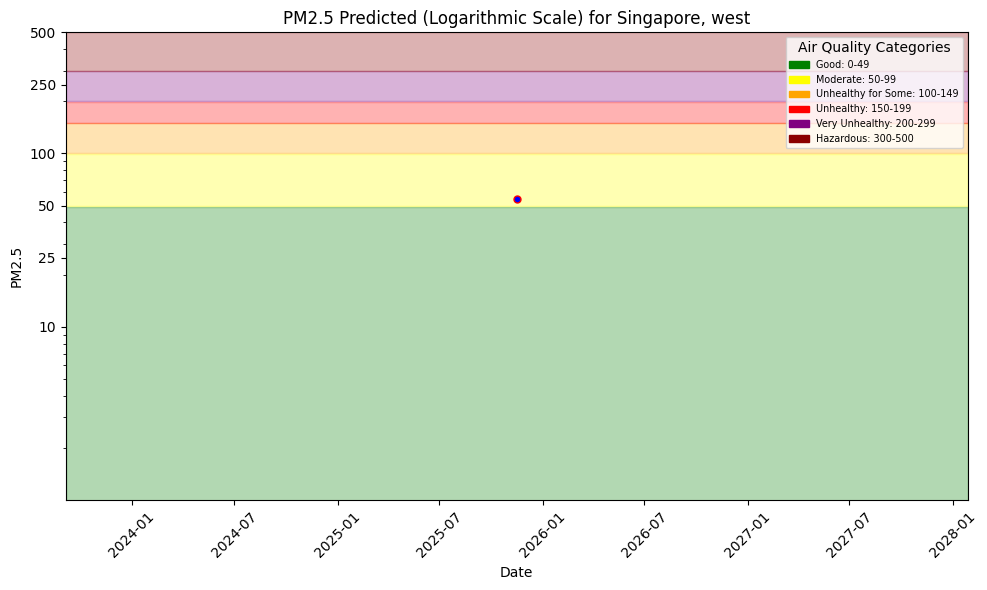

In [185]:
pred_file_path = f"{root_dir}/../air_quality_model/images/pm25_forecast.png"
plt = plot_air_quality_forecast('Singapore', REGION, batch_data, pred_file_path)
plt.show()

In [188]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['region','timestamp','days_before_forecast_day'],
    event_time="timestamp"
)
monitor_fg.insert(batch_data, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1277076/fs/1263683/fg/1718737


Uploading Dataframe: 100.00% |██████████| Rows 1/1 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1277076/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-16 17:33:34,912 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 17:33:38,083 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 17:35:51,469 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 17:35:51,628 INFO: Waiting for log aggregation to finish.
2025-11-16 17:36:13,574 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [189]:
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.74s) 


,region,timestamp,pm25,day_of_week,day_of_month,month,year,is_weekend,pm25_lag_1d,pm25_lag_2d,...,air_temperature_daily_air_temperature_rolling_mean_14d,air_temperature_daily_air_temperature_rolling_std_14d,air_temperature_daily_air_temperature_rolling_min_14d,air_temperature_daily_air_temperature_rolling_max_14d,air_temperature_daily_air_temperature_rolling_mean_28d,air_temperature_daily_air_temperature_rolling_std_28d,air_temperature_daily_air_temperature_rolling_min_28d,air_temperature_daily_air_temperature_rolling_max_28d,predicted_pm25,days_before_forecast_day
0,west,2025-11-16 00:00:00+00:00,8.375,6,16,11,2025,True,63.0,55.0,...,29.064726,0.927884,27.220093,30.325231,28.716997,0.818667,27.220093,30.325231,54.490627,1


In [190]:
def backfill_predictions_for_monitoring(wind_direction_daily_fg, wind_speed_daily_fg, air_temperature_daily_fg, pm25_daily_fg, monitor_fg, model, region):
    # --- 1. Read feature groups from Hopsworks ---
    wd_df = wind_direction_daily_fg.read()   # region, timestamp, wind_direction_*
    ws_df = wind_speed_daily_fg.read()       # region, timestamp, wind_speed_*
    at_df = air_temperature_daily_fg.read()  # region, timestamp, air_temperature_*
    pm_df = pm25_daily_fg.read()             # region, timestamp, pm25 (+ lags/rollings)

    # --- 2. (Optional) filter by region ---
    if region is not None:
        wd_df = wd_df[wd_df["region"] == region]
        ws_df = ws_df[ws_df["region"] == region]
        at_df = at_df[at_df["region"] == region]
        pm_df = pm_df[pm_df["region"] == region]

    # --- 3. Join weather feature groups on (region, timestamp) ---
    # Assumes all three are region-daily, as you just implemented.
    weather_df = (
        wd_df
        .merge(ws_df, on=["region", "timestamp"], how="inner", suffixes=("", "_ws"))
        .merge(at_df, on=["region", "timestamp"], how="inner", suffixes=("", "_at"))
    )


    features_df = (
        weather_df
        .merge(pm_df, on=["region", "timestamp"], how="inner", suffixes=("", "_pm"))
    )
    features_df = features_df.sort_values(by=['timestamp'], ascending=True)
    features_df = features_df.tail(10)
    features_df['predicted_pm25'] = model.predict(features_df[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    df = pd.merge(features_df, pm25_daily_fg[['timestamp','pm25','region']], on=["timestamp", "region"])
    df['days_before_forecast_day'] = 1
    hindcast_df = df
    df = df.drop('pm25', axis=1)
    monitor_fg.insert(df, write_options={"wait_for_job": True})
    return hindcast_df

In [193]:
pm25_daily_fg = pm25_daily_fg.read()
outcome_df = pm25_daily_fg[['timestamp', 'pm25']]
preds_df =  monitoring_df[['timestamp', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="timestamp")
hindcast_df = hindcast_df.sort_values(by=['timestamp'])
# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(wind_direction_daily_fg, wind_speed_daily_fg, air_temperature_daily_fg, pm25_daily_fg, monitor_fg, retrieved_xgboost_model, REGION)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.51s) 


,timestamp,predicted_pm25,pm25
0,2025-11-16 00:00:00+00:00,54.490627,11.541667
1,2025-11-16 00:00:00+00:00,54.490627,12.250000
2,2025-11-16 00:00:00+00:00,54.490627,9.750000
3,2025-11-16 00:00:00+00:00,54.490627,9.541667
4,2025-11-16 00:00:00+00:00,54.490627,8.375000


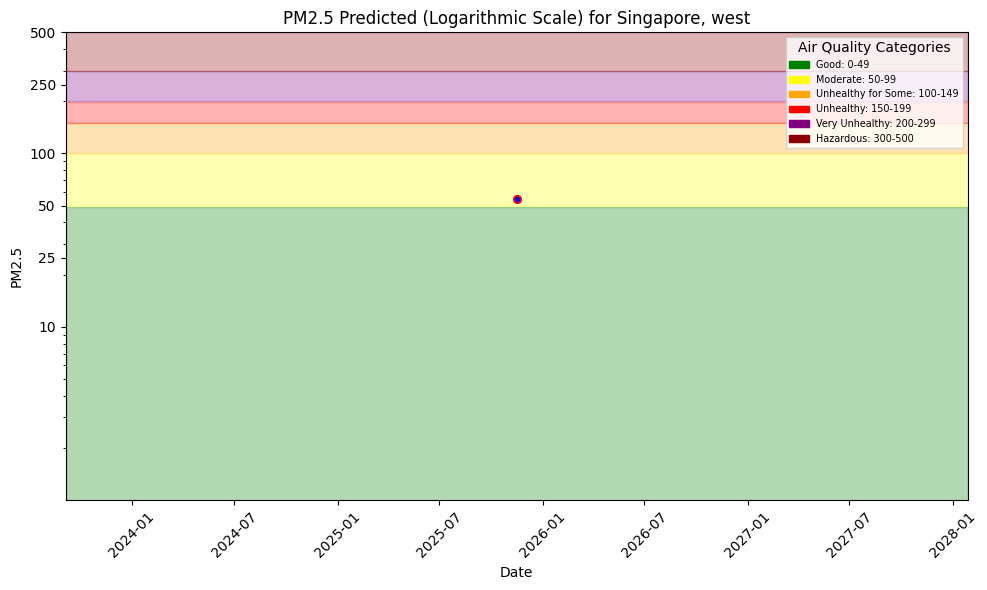

In [196]:
hindcast_path = f"{root_dir}/../air_quality_model/images/pm25_hindcast_1day.png"
plt = plot_air_quality_forecast('Singapore', REGION, hindcast_df, hindcast_path)
plt.show()

In [197]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/singapore_{REGION}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_path, f"Resources/airquality/singapore_{REGION}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Volumes/Data/KTH/ML/air-quality-prediction/notebooks/../air_quality_model/images/pm25_hindcast_1day…

Uploading /Volumes/Data/KTH/ML/air-quality-prediction/notebooks/../air_quality_model/images/pm25_hindcast_1day…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1277076/settings/fb/path/Resources/airquality
